<a href="https://colab.research.google.com/github/Mohamed-Korium/Self-DrivingCar/blob/main/Autonomous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt # For visualizing number. 
import matplotlib.image as mpimg # For visualizing image
from mpl_toolkits.axes_grid1 import ImageGrid # for reading pixal image
import numpy as np # for creating martix
import cv2 # computer vision (for dealing with image)
%matplotlib inline 

In [2]:
from google.colab import drive # to connect with my google drive in orders to upload image
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls #list of drive

drive  sample_data


In [4]:
!ls '/content/drive/My Drive/Colab' # Find path in the file Colab in google drive

Autonomous.ipynb  test_images  test_videos


In [9]:
%cd /content/drive/My Drive/Colab 

/content/drive/My Drive/Colab


In [10]:
!ls

Autonomous.ipynb  test_images  test_videos


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


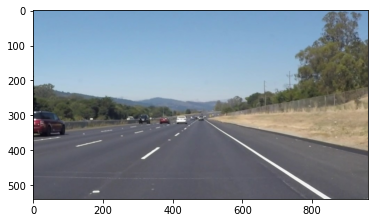

In [11]:
#reading in an image
image = mpimg.imread('test_images/1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray'

In [12]:
import math  #caluclation

def show_img(title, img, cmap=None): #parmaeter of the image
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with #create matrix ZEROS
    mask = np.zeros_like(img)  
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image 


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, orig_img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(orig_img, lines)
    return orig_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [13]:
import os #Operating System
test_images = os.listdir("test_images/")
test_images

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

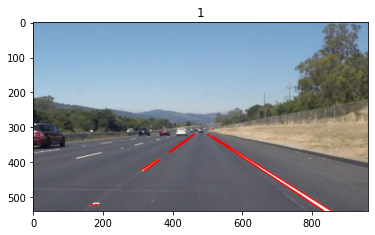

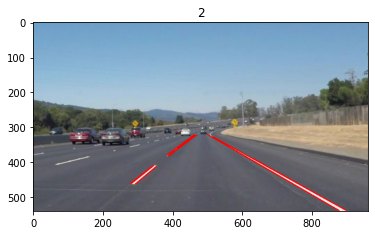

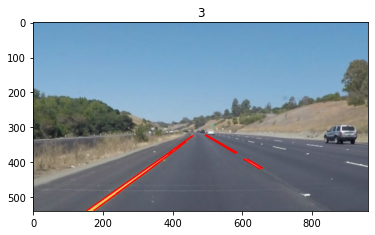

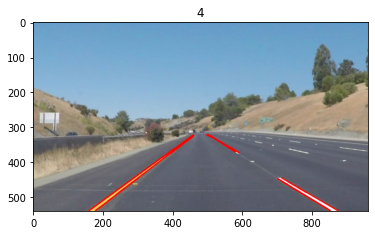

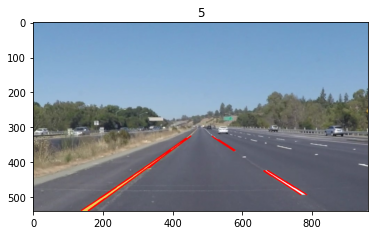

In [14]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def lane_detection_pipeline(image):
    
    gray = grayscale(image)

    blur_gray = gaussian_blur(gray, 5)

    edges = canny(blur_gray, 50, 150)

    imshape = image.shape

    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-20, imshape[0]/2 + 50), (imshape[1]/2+20, imshape[0]/2+50), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #plt.imshow(masked_edges)

    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 20   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, image)

    return line_image

for i in range(5):
    image = mpimg.imread('test_images/' + test_images[i])
    show_img(test_images[i][:-4], lane_detection_pipeline(image))  # The AxesGrid object work as a list of axes.

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3727360/45929032 bytes (8.1%)7913472/45929032 bytes (17.2%)11747328/45929032 bytes (25.6%)15646720/45929032 bytes (34.1%)19742720/45929032 bytes (43.0%)23650304/45929032 bytes (51.5%)27557888/45929032 bytes (60.0%)31588352/45929032 bytes (68.8%)35659776/45929032 bytes (77.6%)39403520/45929032 bytes (85.8%)43180032/45929032 bytes (94.0%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = lane_detection_pipeline(image)
    return result

In [17]:
!ls '/content/drive/My Drive/Colab/test_videos'


challenge.mp4  solidWhiteRight.mp4  solidYellowLeft.mp4


In [19]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 24.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.81 s, sys: 286 ms, total: 3.1 s
Wall time: 10.3 s


In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:29<00:00, 23.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.75 s, sys: 783 ms, total: 9.53 s
Wall time: 30.8 s


In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:22<00:00, 11.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.53 s, sys: 546 ms, total: 7.07 s
Wall time: 24.9 s
